Currency Return as of 20230718 (BGN, vsUSD)


,Currency,1D,vs06/30,vs03/31,Carry
0,SEK,0.3%,5.7%,1.8%,-1.8%
1,CHF,0.3%,4.4%,6.7%,-3.8%
2,CAD,0.2%,0.6%,2.6%,-0.5%
3,NOK,0.1%,6.9%,4.2%,-1.5%
4,EUR,-0.1%,2.9%,3.6%,-1.9%
5,AUD,-0.1%,2.2%,1.9%,-1.2%
6,JPY,-0.1%,3.9%,-4.3%,-5.5%
7,CNY,-0.2%,0.9%,-4.4%,-3.2%
8,GBP,-0.3%,2.6%,5.7%,-0.2%
9,NZD,-0.8%,2.4%,0.2%,0.1%


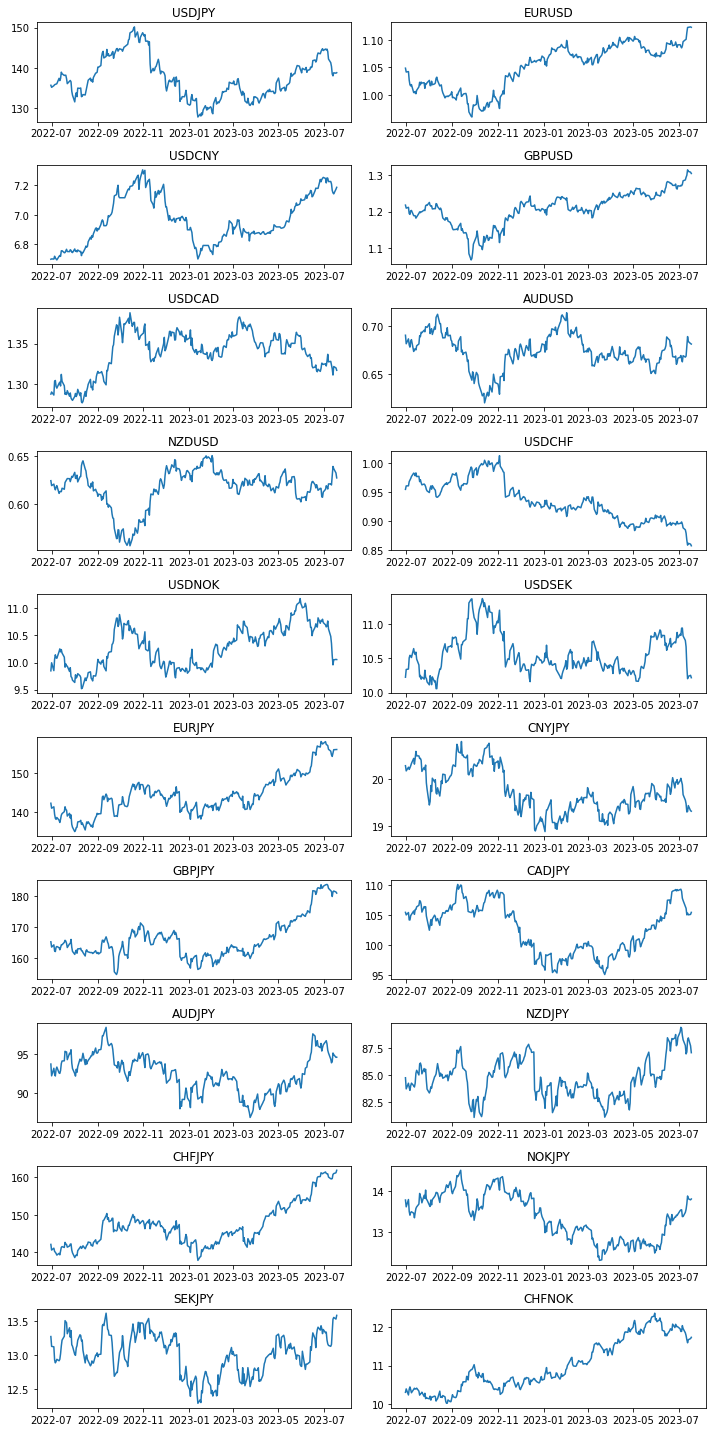

In [1]:
import os
path = r"C:/Users/ky090/OneDrive - The University of Texas at Austin/001_Market/005_Python"
path = path.replace("\\", "/")
os.chdir(path)
print(os.getcwd())
# https://smart-hint.com/python/style/
# https://www.salesanalytics.co.jp/datascience/datascience046/

%matplotlib inline
%run -m FX_Rank

## The following code is the same code as in FX_Rank.py

In [1]:
import pdblp
from xbbg import blp
import workdays
import time
import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import calendar
import base64
import matplotlib.pyplot as plt
import os
pd.set_option('display.max_columns', 70)

In [2]:
ODA = workdays.workday(date.today(), days=-1).strftime("%Y%m%d") #One day agp
TDA= workdays.workday(date.today(), days=-2)  #Two days ago
OYA = TDA - relativedelta(months=13)
OYA = OYA.replace(day=calendar.monthrange(OYA.year, OYA.month)[1]) #One year ago

if TDA.month > 3 or (TDA.month == 3 and TDA.day == 31):
    YE = date(TDA.year, 3, 31).strftime("%Y%m%d")
else:
    YE = date(TDA.year - 1, 3, 31).strftime("%Y%m%d")
    
L = ["JPY","EUR","CNY","GBP","CAD","AUD","NZD","CHF","NOK","SEK"]
T = [i + "USD BGN Curncy" for i in L] 
df = blp.bdh(T, "px_last", YE, ODA, Days="W", Fill="P").reset_index()
df = df[["index"]+T]
df.columns = ["Date"] + L
df

,Date,JPY,EUR,CNY,GBP,CAD,AUD,NZD,CHF,NOK,SEK
0,2023-03-31,0.007527,1.0839,0.14548,1.2337,0.7398,0.6685,0.6258,1.0926,0.0955,0.096114
1,2023-04-03,0.007549,1.0899,0.14540,1.2414,0.7442,0.6786,0.6297,1.0959,0.0971,0.096403
2,2023-04-04,0.007592,1.0953,0.14536,1.2501,0.7438,0.6751,0.6313,1.1037,0.0970,0.097301
3,2023-04-05,0.007615,1.0904,0.14536,1.2462,0.7431,0.6720,0.6318,1.1028,0.0958,0.096124
4,2023-04-06,0.007588,1.0922,0.14550,1.2440,0.7411,0.6672,0.6243,1.1056,0.0957,0.095894
...,...,...,...,...,...,...,...,...,...,...,...
133,2023-10-04,0.006706,1.0504,0.13702,1.2135,0.7275,0.6325,0.5913,1.0902,0.0909,0.090356
134,2023-10-05,0.006734,1.0550,0.13702,1.2192,0.7297,0.6370,0.5966,1.0961,0.0912,0.090858
135,2023-10-06,0.006697,1.0586,0.13702,1.2237,0.7320,0.6386,0.5990,1.0991,0.0916,0.091231
136,2023-10-09,0.006734,1.0567,0.13713,1.2238,0.7359,0.6411,0.6023,1.1030,0.0927,0.091199


In [3]:
T0 = [i + " BGN Curncy" for i in L]
T1 = [i + "1M BGN Curncy" for i in L]
T1 = [x.replace("CNY", "CNH") for x in T1]

BDP0 = blp.bdp(tickers=T0, flds=["px_last","fwd_scale","is_pct_chg_app_base_crncy"]).loc[T0,:]
BDP1 = blp.bdp(tickers=T1, flds=["px_last"]).loc[T1,:]
BDP = BDP0.reset_index(drop=True)
BDP.insert(0, "Curncy", L)
BDP.insert(2, "frd_point", BDP1["px_last"].tolist())
BDP.insert(3, "Carry", 0)
BDP["Carry"] = (1 + BDP["frd_point"] / BDP["px_last"] / 10 ** BDP["fwd_scale"] ) ** 12 - 1

BDP

,Curncy,px_last,frd_point,Carry,fwd_scale,is_pct_chg_app_base_crncy
0,JPY,148.84,-73.19,-0.057438,2,Y
1,EUR,1.0609,13.35,0.015205,4,N
2,CNY,7.2982,-105.00,-0.017129,4,Y
3,GBP,1.2285,2.17,0.002122,4,N
4,CAD,1.3589,-6.56,-0.005778,4,Y
5,AUD,0.6421,7.44,0.013993,4,N
6,NZD,0.6026,0.36,0.000717,4,N
7,CHF,0.9043,-29.50,-0.038452,4,Y
8,NOK,10.7891,-95.85,-0.010609,4,Y
9,SEK,10.8685,-136.57,-0.014975,4,Y


In [4]:
L2 = [row['Curncy'] + 'USD' if row['is_pct_chg_app_base_crncy'] == 'N' else 'USD' + row['Curncy'] for _, row in BDP.iterrows()]
L2 += [i + "JPY" for i in L[1:]] + ["CHFNOK"]
T2 = [i + " BGN Curncy" for i in L2]
df2 = blp.bdh(T2, "px_last", OYA, ODA, Days="W", Fill="P").reset_index()
df2 = df2[["index"]+T2]
df2.columns = ["Date"] + L2
df2

,Date,USDJPY,EURUSD,USDCNY,GBPUSD,USDCAD,AUDUSD,NZDUSD,USDCHF,USDNOK,USDSEK,EURJPY,CNYJPY,GBPJPY,CADJPY,AUDJPY,NZDJPY,CHFJPY,NOKJPY,SEKJPY,CHFNOK
0,2022-09-30,144.74,0.9802,7.1159,1.1170,1.3829,0.6400,0.5600,0.9870,10.8862,11.0892,141.88,20.320,161.607,104.667,92.653,81.034,146.643,13.2906,13.0390,11.0232
1,2022-10-03,144.55,0.9826,7.1159,1.1323,1.3624,0.6516,0.5722,0.9923,10.6518,11.0179,142.02,20.271,163.691,106.092,94.178,82.713,145.653,13.5713,13.1215,10.7315
2,2022-10-04,144.13,0.9986,7.1159,1.1476,1.3513,0.6501,0.5731,0.9797,10.4356,10.8475,143.93,20.283,165.396,106.574,93.723,82.590,147.021,13.8098,13.2891,10.7642
3,2022-10-05,144.64,0.9884,7.1159,1.1326,1.3619,0.6488,0.5739,0.9838,10.5083,10.9847,142.89,20.341,163.883,106.178,93.893,82.990,147.040,13.7350,13.1841,10.6800
4,2022-10-06,145.14,0.9791,7.1159,1.1162,1.3748,0.6406,0.5661,0.9907,10.7229,11.1431,142.10,20.344,162.001,105.574,93.016,82.159,146.510,13.5371,13.0120,10.8211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2023-10-04,149.12,1.0504,7.2980,1.2135,1.3745,0.6325,0.5913,0.9172,10.9981,11.0673,156.65,20.412,180.973,108.496,94.325,88.142,162.583,13.5457,13.4728,12.0023
264,2023-10-05,148.51,1.0550,7.2980,1.2192,1.3705,0.6370,0.5966,0.9123,10.9603,11.0061,156.69,20.335,181.067,108.371,94.603,88.590,162.765,13.5543,13.4927,12.0099
265,2023-10-06,149.32,1.0586,7.2980,1.2237,1.3661,0.6386,0.5990,0.9098,10.9167,10.9625,158.07,20.507,182.730,109.314,95.340,89.428,164.028,13.6753,13.6261,11.9988
266,2023-10-09,148.51,1.0567,7.2926,1.2238,1.3590,0.6411,0.6023,0.9066,10.7839,10.9650,156.93,20.360,181.740,109.283,95.207,89.433,163.803,13.7710,13.5410,11.8959


C:\Users\A1800401\AppData\Local\Temp\ipykernel_36880\1411533978.py:28: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  .render()


Currency Return as of 20231010 (BGN, vsUSD)


,Currency,1D,vs09/29,vs03/31,Carry
0,SEK,0.8%,0.3%,-4.3%,-1.5%
1,GBP,0.4%,0.7%,-0.4%,-0.2%
2,NZD,0.4%,0.8%,-3.4%,-0.1%
3,EUR,0.4%,0.3%,-2.2%,-1.5%
4,AUD,0.3%,-0.0%,-3.8%,-1.4%
5,CHF,0.2%,1.2%,1.2%,-3.8%
6,CAD,0.0%,-0.0%,-0.5%,-0.6%
7,CNY,-0.0%,0.1%,-5.8%,-1.7%
8,JPY,-0.1%,0.4%,-10.7%,-5.7%
9,NOK,-0.2%,-1.1%,-3.1%,-1.1%


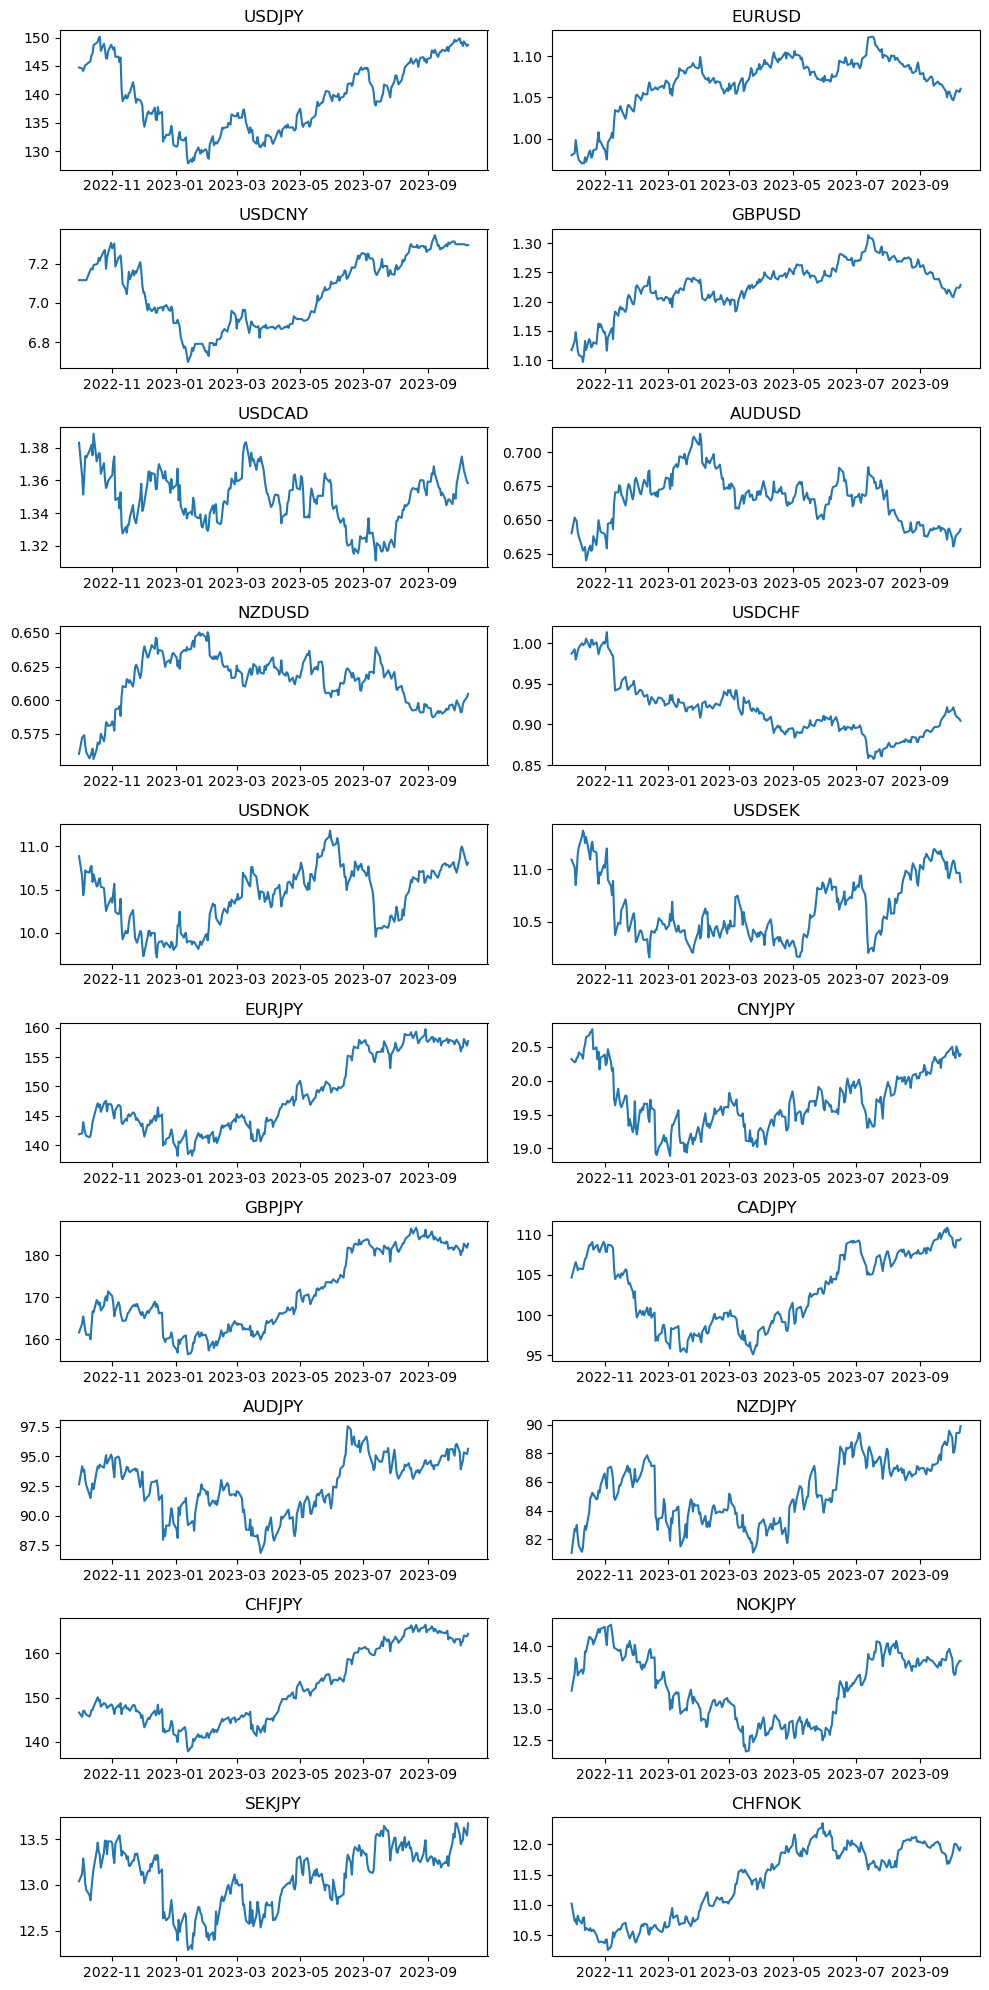

In [5]:
TDA= workdays.workday(date.today(), days=-2) #Two days ago
# ME = (date(TDA.year, TDA.month, 1) + relativedelta(months=-1, day=31)).strftime("%Y/%m/%d") #Month End
ME = date(TDA.year, TDA.month, 1) + relativedelta(months=0, day=1)
ME = workdays.workday(ME, days=-1).strftime("%Y/%m/%d")
YE = date(TDA.year, 3, 31) if TDA.month > 3 or (TDA.month == 3 and TDA.day == 31) else date(TDA.year - 1, 3, 31) #Year End
YE = YE.strftime("%Y/%m/%d")
TDA = TDA.strftime("%Y/%m/%d")  

C = ["TDA","ME","YE"]
FX = pd.DataFrame(L, columns=["Curncy"])
df["Date"] = pd.to_datetime(df["Date"])
tmp = df.loc[len(df)-1, L]

for i in C:
    exec(f"d = {i}")
    FX[i] = (tmp / df.loc[df["Date"]==d, L] - 1).values[0]

FX["Carry"] = np.where(BDP["is_pct_chg_app_base_crncy"] == "Y", BDP["Carry"], -BDP["Carry"])
FX.sort_values(by="TDA", ascending=False, inplace=True)
FX = FX.reset_index(drop=True)

C = ["Currency","1D","vs"+ME[5:],"vs"+YE[5:],"Carry"]
FX.columns= C

html = FX.style\
    .bar(subset=C[1:], align='mid', color=["pink", "lightblue"])\
    .format({c: '{:.1%}' for c in C[1:]})\
    .render()
tmp = len(L2) // 2 + len(L2) % 2
fig, ax = plt.subplots(tmp, 2,figsize=(10,tmp*2),tight_layout=True)
for i in range(len(L2)):
    ax[i//2,i%2].plot(df2["Date"], df2[L2[i]])
    ax[i//2,i%2].set_title(L2[i])
plt.savefig("tmp.png")

with open("tmp.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()
html += f'<img src="data:image/png;base64,{encoded_string}">'
path = r"C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\100_Output"
path = path.replace("\\", "/")
os.chdir(path)
print(os.getcwd())
with open("FX_" + datetime.now().strftime('%Y%m%d') + ".html", "w") as f:
    f.write(html)
    

print("Currency Return as of "+ODA+" (BGN, vsUSD)")

display(FX.style\
        .bar(subset=C[1:], align='mid', color=["pink", "lightblue"])\
        .format({c: '{:.1%}' for c in C[1:]})\
       )

plt.show()